In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras 
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import InputLayer, BatchNormalization,Activation, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19 
import tqdm
import keras
import glob
import cv2
import warnings
from keras.preprocessing import image
import numpy as np
warnings.filterwarnings("ignore")
import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)

Num GPUs Available:  0


In [4]:
batch_size=60
img_size=(224,224)
image_generator = ImageDataGenerator(rescale=1/255., validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     
train_data = image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimers-ADNI\\train',shuffle=True,target_size=img_size, subset="training",class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.8) 
validation_data= image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimers-ADNI\\test',shuffle=True,target_size=img_size,class_mode='categorical')

submission = image_generator.flow_from_directory(directory='F:\Alzheimers-ADNI\\test',shuffle=False,subset="validation",target_size=img_size, class_mode=None)

Found 1101 images belonging to 5 classes.


Found 195 images belonging to 5 classes.
Found 153 images belonging to 5 classes.


In [5]:
train_data.class_indices

{'Final AD JPEG': 0,
 'Final CN JPEG': 1,
 'Final EMCI JPEG': 2,
 'Final LMCI JPEG': 3,
 'Final MCI JPEG': 4}

In [6]:
batch_size=60
epoch=10
callback= keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)

In [7]:
vgg19 = VGG19(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

for layer in vgg19.layers:
    layer.trainable = False


x = Flatten()(vgg19.output)
x = Dense(128, activation='relu')(x)
out = Dense(5, activation='softmax')(x)

modelvgg19 = Model(inputs=vgg19.input, outputs=out)

# compiling
modelvgg19.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


modelvgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
hist_vgg19=modelvgg19.fit(train_data,epochs=20, validation_data=validation_data)

Epoch 1/20
19/19 [==============================] - 215s 11s/step - loss: 2.9019 - accuracy: 0.3506 - val_loss: 1.4149 - val_accuracy: 0.4462
Epoch 2/20
19/19 [==============================] - 216s 11s/step - loss: 1.3887 - accuracy: 0.4441 - val_loss: 1.4320 - val_accuracy: 0.4462
Epoch 3/20
19/19 [==============================] - 224s 12s/step - loss: 1.3515 - accuracy: 0.4705 - val_loss: 1.3828 - val_accuracy: 0.4769
Epoch 4/20
19/19 [==============================] - 244s 13s/step - loss: 1.2416 - accuracy: 0.5232 - val_loss: 1.4902 - val_accuracy: 0.4667
Epoch 5/20
19/19 [==============================] - 254s 13s/step - loss: 1.2711 - accuracy: 0.4868 - val_loss: 1.3728 - val_accuracy: 0.4974
Epoch 6/20
19/19 [==============================] - 242s 13s/step - loss: 1.1237 - accuracy: 0.5876 - val_loss: 1.3950 - val_accuracy: 0.4205
Epoch 7/20
19/19 [==============================] - 325s 17s/step - loss: 1.0675 - accuracy: 0.5976 - val_loss: 1.3954 - val_accuracy: 0.4359
Epoch 

In [9]:
loss_vgg19,accuracy_vgg19= modelvgg19.evaluate(validation_data)

4/4 [==============================] - 34s 8s/step - loss: 1.3859 - accuracy: 0.4462


In [10]:
Y_pred = modelvgg19.predict_generator(validation_data, 1000 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data.classes, y_pred))
print('Classification Report')
target_names = ['Final AD JPEG','Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG','Final MCI JPEG']
print(classification_report(validation_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 3 19  1  0  3]
 [15 55  7  1  9]
 [ 6 20  6  0  4]
 [ 0  7  1  0  3]
 [ 5 22  2  0  6]]
Classification Report
                 precision    recall  f1-score   support

  Final AD JPEG       0.10      0.12      0.11        26
  Final CN JPEG       0.45      0.63      0.52        87
Final EMCI JPEG       0.35      0.17      0.23        36
Final LMCI JPEG       0.00      0.00      0.00        11
 Final MCI JPEG       0.24      0.17      0.20        35

       accuracy                           0.36       195
      macro avg       0.23      0.22      0.21       195
   weighted avg       0.32      0.36      0.33       195



Save Model for Future Use

In [11]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "vgg19ADNI.pkl"  
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(modelvgg19, file)

In [12]:
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

by diffrent method 

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.13.0


In [2]:
WORK_DIR = './Alzheimers-ADNI'

CLASSES = [ 'Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [3]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 1296 images belonging to 5 classes.


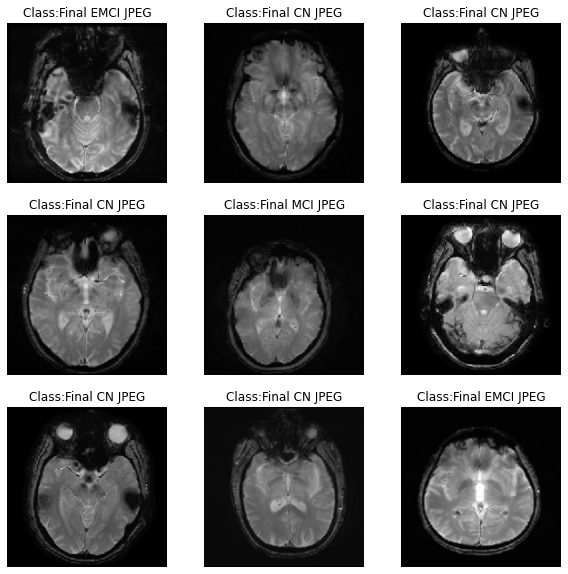

In [6]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1296)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [7]:
train_data, train_labels = train_data_gen.next()

In [8]:
print(train_data.shape, train_labels.shape)

(1296, 176, 176, 3) (1296, 5)


In [9]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2900, 176, 176, 3) (2900, 5)


In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [13]:
vgg19_model = VGG19(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [14]:
for layer in vgg19_model.layers:
    layer.trainable=False

In [15]:
custom_vgg19_model = Sequential([
        vgg19_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(5, activation='softmax')        
    ], name = "resnet_cnn_model")

In [16]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [17]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# CALLBACKS = rop_callback
    
custom_vgg19_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_vgg19_model.summary()

Model: "resnet_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)          

In [19]:
EPOCHS = 15

history = custom_vgg19_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,steps_per_epoch=128)

Epoch 1/15
128/128 [==============================] - 265s 2s/step - loss: 2.0288 - accuracy: 0.7531 - precision: 0.2239 - recall: 0.0950 - auc: 0.5216 - f1_score: 0.1316 - val_loss: 1.6186 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5127 - val_f1_score: 0.0000e+00
Epoch 2/15
128/128 [==============================] - 323s 3s/step - loss: 1.8553 - accuracy: 0.7656 - precision: 0.2454 - recall: 0.0830 - auc: 0.5495 - f1_score: 0.1210 - val_loss: 1.5865 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5752 - val_f1_score: 0.0000e+00
Epoch 3/15
128/128 [==============================] - 360s 3s/step - loss: 1.7542 - accuracy: 0.7799 - precision: 0.2916 - recall: 0.0705 - auc: 0.5644 - f1_score: 0.1100 - val_loss: 1.5633 - val_accuracy: 0.7991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6052 - val_f1_score: 0.0000e+00
Epoch 4/15
128/128 [==============================] - 348s 3s/step 

In [20]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_vgg19_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

19/19 [==============================] - 78s 4s/step - loss: 1.2517 - accuracy: 0.8238 - precision: 0.7117 - recall: 0.2000 - auc: 0.7900 - f1_score: 0.2939
Testing Accuracy: 82.38%


In [21]:
pred_labels = custom_vgg19_model.predict(test_data)

19/19 [==============================] - 60s 3s/step


In [48]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                 precision    recall  f1-score   support

  Final AD JPEG       0.57      0.24      0.34       112
  Final CN JPEG       0.40      0.61      0.48       125
Final EMCI JPEG       0.41      0.44      0.42       117
Final LMCI JPEG       0.58      0.83      0.68       116
 Final MCI JPEG       0.33      0.16      0.22       110

      micro avg       0.46      0.46      0.46       580
      macro avg       0.46      0.46      0.43       580
   weighted avg       0.46      0.46      0.43       580
    samples avg       0.46      0.46      0.46       580



In [32]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "vgg19ADNI2.pkl"  
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(custom_vgg19_model, file)

In [46]:
custom_vgg19_model.save('vgg19ADNI2.keras') 
print('Model Saved!')

Model Saved!


In [ ]:
model = tf.keras.models.load_model('vgg19ADNI2.keras')

In [52]:
train_data_gen.class_indices

{'Final AD JPEG': 0,
 'Final CN JPEG': 1,
 'Final EMCI JPEG': 2,
 'Final LMCI JPEG': 3,
 'Final MCI JPEG': 4}

In [58]:
from keras.preprocessing import image
path="F:\Alzheimers-ADNI\\test\\Final AD JPEG\\ADNI_002_S_4521_MR_Axial_T2-Star__br_raw_20160324122521837_22_S402609_I662501.jpg"
img=image.load_img(path,target_size=(176,176))

In [ ]:
custom_vgg19_model.predict(img)